# Tutorial on preventing particles getting stuck

In [this notebook](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_stuck_particles.ipynb), we have shown how particles may end up getting stuck on land, especially in A gridded velocity fields. Here we show how you can work around this problem and how large the change in trajectory is.

Common solutions are:
1. [Displace the particles when they are within a certain distance of the coast.](#1.-Displacement)
2. #TODO Move the particle to its previous position. This is especially relevant when random walks are included.
3. #TODO Reduce the landward component of the particle velocity

**Question: How to explain when to start this 'prevention'?**

**E.g. 1. when particle is on land - 2. when particle is within distance - 3. velocity tolerance**

<!-- 1. Defining when a particle is 'stuck'
  - When a particle is on a land gridcell
  - When a particle is moving less than a tolerance value
  - When a particle is within a certain distance of the coast
2. Preventing or displacing particles getting stuck
  - Remove the particles
  - Displace particles
  - Modify the velocity field near the coast -->

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import xarray as xr
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field,GeographicPolar,Geographic
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from scipy import interpolate
import cmocean

## 1. Displacement
A simple concept to avoid particles moving onto shore is displacing them as they get close. This is done in [Kaandorp et al. 2020](https://pubs.acs.org/doi/10.1021/acs.est.0c01984) and [Delandmeter and Sebille 2018](https://gmd.copernicus.org/articles/12/3571/2019/) for example. To do so, a particle must be 'aware' of where the shore is and displaced accordingly. In Parcels, we can do this by adding a 'displacement' `Field` to the `Fieldset`, which contains vectors pointing away from shore. 
#### Import one of the velocity fields that you use for your simulation. I'm using CMEMS 1/12 degree.

In [13]:
file_path = "SMOC_20190704_R20190705.nc"
# indices = {'lat': range(1400, 1700), 'lon': range(2000, 2320)}
latmin = 1595
latmax = 1612
lonmin = 2235
lonmax = 2260

In [14]:
model = xr.load_dataset(file_path)

In [15]:
lons = model['longitude']
lats = model['latitude']
X, Y = np.meshgrid(lons, lats)
X_plot = X[latmin:latmax,lonmin:lonmax]
Y_plot = Y[latmin:latmax,lonmin:lonmax]

# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
dlon = model['longitude'][1]-model['longitude'][0] # 1/12 degree
dlat = model['latitude'][1]-model['latitude'][0]   # 1/12 degree

# Outside corner coordinates - coordinates + 0.5 dx
x_outcorners,y_outcorners = np.meshgrid(np.append((model['longitude']-0.5*dlon),(model['longitude'][-1]+0.5*dlon)),
                np.append((model['latitude']-0.5*dlat),(model['latitude'][-1]+0.5*dlat)))

# Inside corner coordinates - coordinates + 0.5 dx - needed to plot cells inbetween velocity field nodes 
x_incorners,y_incorners = np.meshgrid((model['longitude']+0.5*dlon)[:-1],
                (model['latitude']+0.5*dlat)[:-1])

# Center coordinates
x_centers, y_centers = np.meshgrid(model['longitude'],
                model['latitude'])

####  Make a land mask where `land = 1` and `ocean = 0`.

In [16]:
def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask

In [17]:
landmask = make_landmask(file_path)

In [18]:
# Interpolate the landmask to the inside corners to correctly show pcolormesh
fl = interpolate.interp2d(model['longitude'],model['latitude'],landmask) # Interpolator U

l_corners = fl(x_incorners[0,:],y_incorners[:,0])  

lmask = np.ma.masked_values(l_corners,1)                                 # Masking the interpolated flowfield where U = 0

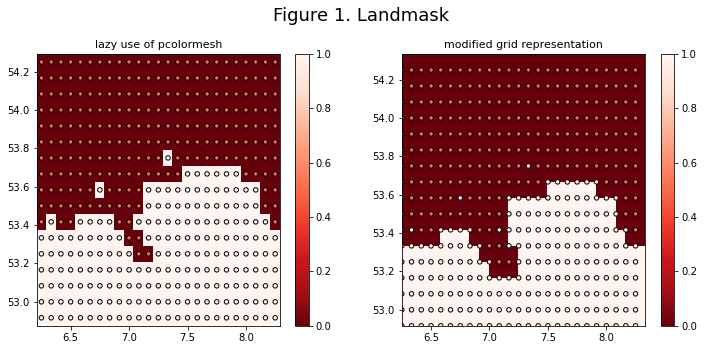

In [19]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.01)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title('lazy use of pcolormesh', fontsize=11)
land0 = ax0.pcolormesh(X_plot, Y_plot, landmask[latmin:latmax,lonmin:lonmax],cmap='Reds_r', shading='auto')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')
plt.colorbar(land0, ax=ax0)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title('modified grid representation', fontsize=11)
land1 = ax1.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')
plt.colorbar(land1, ax=ax1)

#### Detect the coast

By computing 

$$\partial_{xx} \text{landmask} + \partial_{yy} \text{landmask}$$

and filtering the positve and negative values we can detect the edges, in this case the coast (ocean cells next to land) and the shore (land cells next to the ocean).

In [20]:
def get_coastal_cells(landmask):
    """Function that detects the coastal cells, i.e. the ocean cells directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal cells, the coastal cells are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_cells(landmask):
    """Function that detects the shore cells, i.e. the land cells directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore cells, the shore cells are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

In [21]:
coastal = get_coastal_cells(landmask)
shore = get_shore_cells(landmask)

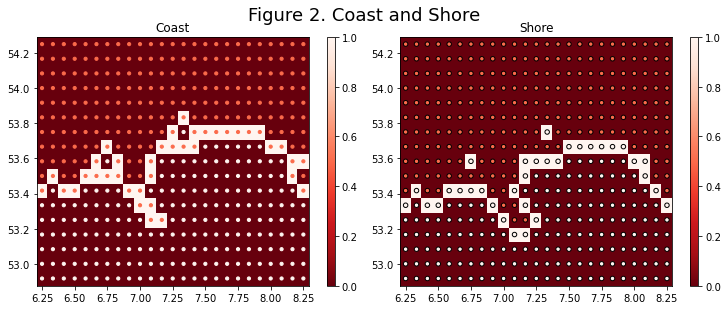

In [22]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
fig.suptitle('Figure 2. Coast and Shore', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
coa = ax0.pcolormesh(X_plot,Y_plot, coastal[latmin:latmax,lonmin:lonmax], cmap='Reds_r', shading='auto')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=10,cmap='Reds_r',vmin=-0.05,vmax=0.05)
ax0.set_title('Coast')
plt.colorbar(coa,ax=ax0, aspect=80)

ax1 = fig.add_subplot(gs[0, 1])
sho = ax1.pcolormesh(X_plot,Y_plot, shore[latmin:latmax,lonmin:lonmax], cmap='Reds_r', shading='auto')
ax1.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
ax1.set_title('Shore')
plt.colorbar(sho,ax=ax1, aspect=80)

#### Assigning coastal velocities

For the displacement kernel we define a velocity field that pushes the particles back to the ocean. This velocity has to be a vector normal to the coast. For this we can take the simple derivative of `landmask` and project the result to the `coastal` array, this will capture the orientation of the velocity vectors. then to make this vectors unitary, we can normalize by it's magnitude.

In [23]:
def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask built using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_cells(landmask)
    coastal = get_coastal_cells(landmask)
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    if double_cell:
        v_x = -Lx*(coastal+shore) 
        v_y = -Ly*(coastal+shore)
    else:
        v_x = -Lx*(shore)
        v_y = -Ly*(shore)

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal cells between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

In [24]:
v_x, v_y = create_displacement_field(landmask)
# np.save('coastal_u.npy', v_x)
# np.save('coastal_v.npy', v_y)

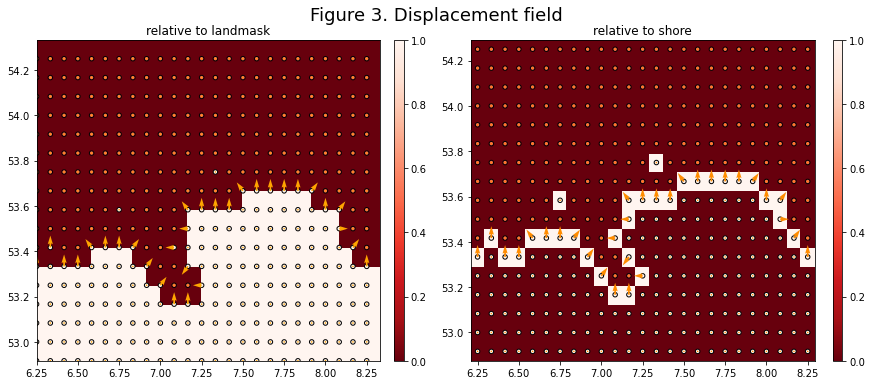

In [25]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
fig.suptitle('Figure 3. Displacement field', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land = ax0.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax0.quiver(X_plot,Y_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange',angles='xy', scale_units='xy', scale=19, width=0.005)
# ax0.set_xlim(5, 9)
# ax0.set_ylim(52, 55)
ax0.set_title('relative to landmask')
plt.colorbar(land,ax=ax0, aspect=80)

ax1 = fig.add_subplot(gs[0, 1])
sho = ax1.pcolormesh(X_plot,Y_plot, shore[latmin:latmax,lonmin:lonmax], cmap='Reds_r', shading='auto')
ax1.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax1.quiver(X_plot,Y_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='darkorange',angles='xy', scale_units='xy', scale=19, width=0.005)
# ax0.set_xlim(5, 9)
# ax0.set_ylim(52, 55)
ax1.set_title('relative to shore')
plt.colorbar(sho,ax=ax1, aspect=80)

In [26]:
def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_cells` algorithm.

    - landmask: the land mask built using `make_landmask` function.
    - dx: the grid cell dimesion. This is a crude approximation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_cells(landmask)
    landmask_i = landmask + ci
    dist = ci
    i = 0

    while i < dist.max():
        ci = get_coastal_cells(landmask_i)
        landmask_i += ci
        dist += ci*(i+2)
        i += 1
        
    return dist*dx

In [27]:
# d_2_s = distance_to_shore(landmask)
# np.save('distance_2_shore.npy', d_2_s)
d_2_s = np.load('distance_2_shore.npy')

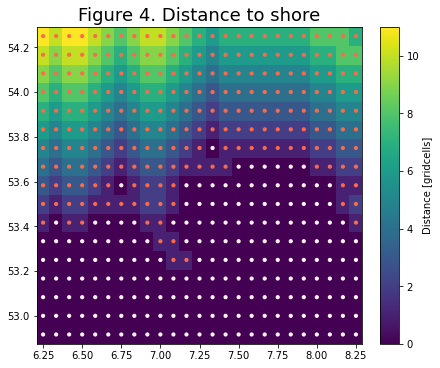

In [28]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Figure 4. Distance to shore', fontsize=18)
d2s = ax0.pcolormesh(X_plot,Y_plot, d_2_s[latmin:latmax,lonmin:lonmax], shading='auto')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=10,cmap='Reds_r',vmin=-0.05,vmax=0.05)
plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]')

In [29]:
SMOCfile = 'SMOC_201907*.nc'
filenames = {'U': SMOCfile,
             'V': SMOCfile}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [30]:
u_border = v_x #np.load('coastal_u.npy')
v_border = v_y #np.load('coastal_v.npy')
fieldset.add_field(Field('borU', data=u_border,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.add_field(Field('borV', data=v_border,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.borU.units = GeographicPolar()
fieldset.borV.units = Geographic()

In [31]:
landID = landmask

In [32]:
fieldset.add_field(Field('landmask', landID,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.add_field(Field('distance2shore', d_2_s,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))

In [33]:
class LandParticle(JITParticle):
    on_land = Variable('on_land')
    bU = Variable('bU')
    bV = Variable('bV')
    d2s = Variable('d2s', initial=1e3)
    
def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]
    particle.d2s = fieldset.distance2shore[time, particle.depth,
                               particle.lat, particle.lon]
    if  particle.d2s < 0.5:
        borUab = fieldset.borU[time, particle.depth, particle.lat,
                               particle.lon]
        borVab = fieldset.borV[time, particle.depth, particle.lat,
                               particle.lon]
        particle.bU = borUab
        particle.bV = borVab
    else:
        particle.bU = 0.
        particle.bV = 0.
    
def AntiBeachNudging(particle, fieldset, time):
    """
    The nudging current is 1 m s^-1, which ought to be sufficient to overpower
    any coastal current (I hope) and push our particle back out to sea so as to
    not get stuck
    update 11/03/2020: Following tests and discussions with Cleo, the nudging
    current will now kick in starting at 500m from the coast, since otherwise
    the particles tended to get stuck if we used the velocity treshhold.
    """
    
    if  particle.d2s < 0.5:
        particle.lon += particle.bU*particle.dt
        particle.lat += particle.bV*particle.dt

In [34]:
npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=LandParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AntiBeachNudging)+pset.Kernel(AdvectionRK4)+pset.Kernel(Sample_land)

output_file = pset.ParticleFile(name="SMOC-disp.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=119), dt=delta(hours=1),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled ArrayLandParticleAntiBeachNudgingAdvectionRK4Sample_land ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib553c03b7af30ed60ec9a938b7cf83a39_0.dll
INFO: Temporary output files are stored in out-DDXNALJZ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-DDXNALJZ" to convert these to a NetCDF file during the run.
100% (428400.0 of 428400.0) |############| Elapsed Time: 0:01:32 Time:  0:01:32


In [35]:
ds_SMOC = xr.open_dataset('SMOC.nc')
ds_SMOC_disp = xr.open_dataset('SMOC-disp.nc')

In [36]:
# --------- Velocity fields ---------
cells = np.zeros((len(model['latitude']),len(model['longitude']))) # Empty cells between coordinate nodes - essentially on inside corners

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0
my_cmap = ListedColormap(my_cmap)

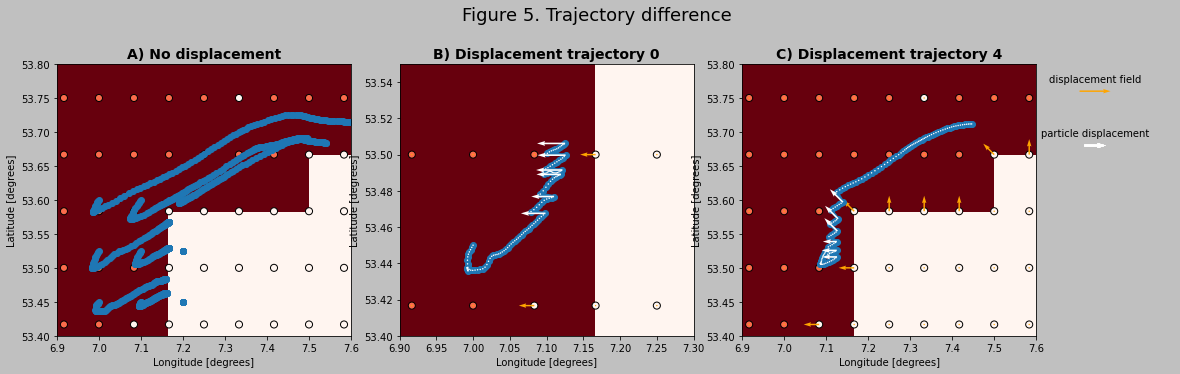

In [56]:
fig = plt.figure(figsize=(20,5), facecolor='silver')
fig.suptitle('Figure 5. Trajectory difference', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[1,1,1,0.3], figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')
ax0.set_title('A) No displacement', fontsize=14, fontweight = 'bold')
ax0.set_xlim(6.9, 7.6)
ax0.set_ylim(53.4, 53.8)

land = ax0.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
ax0.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC['lon'], ds_SMOC['lat'], cmap='viridis_r', zorder=2)

n_p0 = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('B) Displacement trajectory '+str(n_p0), fontsize=14, fontweight = 'bold')
ax1.set_xlim(6.9, 7.3)
ax1.set_ylim(53.4, 53.55)

land = ax1.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax1.quiver(X_plot,Y_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange', scale=19, width=0.005)
ax1.plot(ds_SMOC_disp['lon'][0].T, ds_SMOC_disp['lat'][0].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC_disp['lon'][0], ds_SMOC_disp['lat'][0], cmap='viridis_r', zorder=2)
ax1.quiver(ds_SMOC_disp['lon'][0], ds_SMOC_disp['lat'][0],ds_SMOC_disp['bU'][0], ds_SMOC_disp['bV'][0], color='w',angles='xy', scale_units='xy', scale=2e-4, zorder=3)

n_p1 = 4
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('C) Displacement trajectory '+str(n_p1), fontsize=14, fontweight = 'bold')
ax2.set_xlim(6.9, 7.6)
ax2.set_ylim(53.4, 53.8)

land = ax2.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax2.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
q1 = ax2.quiver(X_plot,Y_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange', scale=19, width=0.005)
ax2.plot(ds_SMOC_disp['lon'][n_p1].T, ds_SMOC_disp['lat'][n_p1].T,linewidth=3, zorder=1)
ax2.scatter(ds_SMOC_disp['lon'][n_p1], ds_SMOC_disp['lat'][n_p1], cmap='viridis_r', zorder=2)
q2 = ax2.quiver(ds_SMOC_disp['lon'][n_p1], ds_SMOC_disp['lat'][n_p1],ds_SMOC_disp['bU'][n_p1], ds_SMOC_disp['bV'][n_p1], color='w',angles='xy', scale_units='xy', scale=2e-4, zorder=3)


# custom_lines = [Line2D([0], [0], c = 'orange', marker='o', markersize=10),
#                 Line2D([0], [0], c = 'w', marker='o', markersize=10)]
# ax2.legend(custom_lines, ['Stuck', 'Moving'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,framealpha=1)
# ax2.legend()
ax3 = fig.add_subplot(gs[0, 3])
ax3.axis('off')
ax2.quiverkey(q1, 1.2, 0.9, 2, 'displacement field', coordinates='axes')
ax2.quiverkey(q2, 1.2, 0.7, 1e-5, 'particle displacement', coordinates='axes')
plt.show()

In [38]:
d2s_cmap = copy(plt.get_cmap('cmo.deep_r'))
d2s_cmap.set_over('gold')

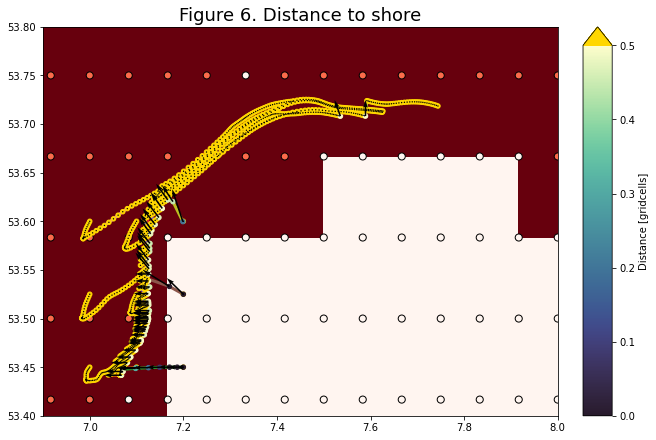

In [57]:
fig = plt.figure(figsize=(9,6), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Figure 6. Distance to shore', fontsize=18)
# d2sd = ax0.scatter(X_plot,Y_plot, c=d_2_s[latmin:latmax,lonmin:lonmax], cmap='viridis', zorder = 2, edgecolor='w')
land = ax0.pcolormesh(x_centers[latmin:latmax+1,lonmin:lonmax+1], y_centers[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(x_centers[latmin:latmax,lonmin:lonmax], y_centers[latmin:latmax,lonmin:lonmax], c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r', edgecolor='k',vmin=-0.05,vmax=0.05)
ax0.plot(ds_SMOC_disp['lon'].T, ds_SMOC_disp['lat'].T,linewidth=3, zorder=1)
d2s = ax0.scatter(ds_SMOC_disp['lon'], ds_SMOC_disp['lat'], c=ds_SMOC_disp['d2s'],cmap=d2s_cmap, s=20,vmax=0.5, zorder=2)
q2 = ax0.quiver(ds_SMOC_disp['lon'], ds_SMOC_disp['lat'],ds_SMOC_disp['bU'], ds_SMOC_disp['bV'], color='k',angles='xy', scale_units='xy', scale=2.3e-4, width=0.003, zorder=3)

ax0.set_xlim(6.9, 8)
ax0.set_ylim(53.4, 53.8)
plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]',extend='max')

In [89]:
ds_SMOC.close()
ds_SMOC_disp.close()